# Analysis of the Temporal Evolution of Loads by Balancing Authority

This notebook analyzes the time series of annual total and peak loads from TELL by Balancing Authority (BA).

In [1]:
# Start by importing the packages we need:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


## Set the Directory Structure

In [4]:
# Identify the top-level directory and the subdirectory where the data will be stored:
data_input_dir =  '/Users/burl878/Documents/IMMM/GODEEP/Data/TELL/Production_Runs/tell_data/'
data_output_dir =  '/Users/burl878/Documents/Code/code_repos/load_analysis/data/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/load_analysis/figures/BAs/'


## Process the TELL Output Files

In [5]:
# Check to see if the processed output file exist and if not then create it:
if os.path.isfile((os.path.join(data_output_dir, 'BA_Load_Time_Series.csv'))) == False:

   # Set the scenarios to process:
   scenarios = ['historic', 'BAU_Climate', 'NetZeroNoCCS_Climate']

   #Initiate a counter and empty dataframe to store the results:
   counter = 0;
   output_df = pd.DataFrame()

   # Loop over the scenarios and process each time series:
   for s in range(len(scenarios)):
       if scenarios[s] == 'historic':
          start_year = 1980; end_year = 2020; interval = 1
       else:
          start_year = 2020; end_year = 2050; interval = 1
        
       # Loop over the years from the start_year to the end_year in 5-year increments:
       for year in range(start_year,end_year,interval):
           # Read in the TELL BA output file for that year and scenario:
           tell_df = pd.read_csv(data_input_dir + 'outputs/tell_output/' + scenarios[s] + '/' + str(year) + '/TELL_Balancing_Authority_Hourly_Load_Data_' + str(year) + '_Scaled_' + str(year) + '.csv')
             
           # Make a list of all of the states in the 'merged_df':
           bas = tell_df['BA_Code'].unique()
         
           # Loop over the BAs and calculate the total and peak load for each year:
           for i in range(len(bas)):
               # Iterate the counter by one:
               counter = counter + 1
            
               # Subset to just the data for the BA being processed:
               subset_df = tell_df[tell_df['BA_Code'].isin([bas[i]])].copy()
          
               # Put the output in a new dataframe:
               output_df.loc[counter, 'Scenario'] = scenarios[s]
               output_df.loc[counter, 'Year'] = int(year)
               output_df.loc[counter, 'BA'] = bas[i]
               output_df.loc[counter, 'Total_Load_TWh'] = (subset_df['Scaled_TELL_BA_Load_MWh'].sum().round(6)) / 1000000
               output_df.loc[counter, 'Peak_Load_MWh'] = subset_df['Scaled_TELL_BA_Load_MWh'].max()
            
               # Clean up
               del subset_df

           # Clean up
           del tell_df, bas
         
   # Initiate an empty normalized load variable:
   output_df['Total_Load_Normalized'] = np.nan
   output_df['Peak_Load_Normalized'] = np.nan

   # Loop over the rows of the dataframe normalize the load by the base year value:
   for row in range(len(output_df)):
       # Find the total load value to normalize by:
       base_load = output_df['Total_Load_TWh'].loc[(output_df['Year'] == 2019) & 
                                                   (output_df['BA'] == output_df['BA'].iloc[row]) & 
                                                   (output_df['Scenario'] == 'historic')].values
    
       # Compute the normalized total load:
       output_df['Total_Load_Normalized'].iloc[row] = (output_df['Total_Load_TWh'].iloc[row] / base_load).round(3)
    
       # Find the peak load value to normalize by:
       peak_load = output_df['Peak_Load_MWh'].loc[(output_df['Year'] == 2019) & 
                                                  (output_df['BA'] == output_df['BA'].iloc[row]) & 
                                                  (output_df['Scenario'] == 'historic')].values
    
       # Compute the normalized peak load:
       output_df['Peak_Load_Normalized'].iloc[row] = (output_df['Peak_Load_MWh'].iloc[row] / peak_load).round(3)
    
       # Clean up
       del base_load, peak_load

   # Write out the dataframe to a .csv file:
   output_df.to_csv((os.path.join(data_output_dir, 'BA_Load_Time_Series.csv')), sep=',', index=False)
   
else:
   # Read in the already processed output file:
   output_df = pd.read_csv((os.path.join(data_output_dir, 'BA_Load_Time_Series.csv')))            
                  
# Preview the future dataframe:
output_df


,Scenario,Year,BA,Total_Load_TWh,Peak_Load_MWh,Total_Load_Normalized,Peak_Load_Normalized
0,historic,1980.0,AEC,1.542388,383.88,0.332,0.387
1,historic,1980.0,AECI,6.728012,1530.58,0.331,0.296
2,historic,1980.0,AVA,6.063781,1220.40,0.493,0.536
3,historic,1980.0,AZPS,7.447695,1783.30,0.239,0.240
4,historic,1980.0,BANC,6.454464,1650.06,0.370,0.398
...,...,...,...,...,...,...,...
5395,NetZeroNoCCS_Climate,2049.0,TPWR,10.471848,1895.61,2.055,2.099
5396,NetZeroNoCCS_Climate,2049.0,TVA,306.755342,59702.82,1.847,1.884
5397,NetZeroNoCCS_Climate,2049.0,WACM,74.392139,12238.15,2.798,2.989
5398,NetZeroNoCCS_Climate,2049.0,WALC,18.410267,3343.75,2.022,2.057


In [7]:
# Define a function to plot the time series of annual demand for each BA:
def plot_ba_load_time_series(ba_to_plot: str, data_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Read in the output file:
    output_df = pd.read_csv((os.path.join(data_output_dir, 'BA_Load_Time_Series.csv')))
    ba_df = output_df[output_df['BA'] == ba_to_plot]
    
    # Subset to the time series for each scenario:
    ba_historic = ba_df[ba_df['Scenario'].isin(['historic'])]
    ba_bau_climate = ba_df[ba_df['Scenario'].isin(['BAU_Climate'])]
    ba_netzeronoccs_climate = ba_df[ba_df['Scenario'].isin(['NetZeroNoCCS_Climate'])]
    
    # Make the raw load plots:
    plt.figure(figsize=(24, 12))
    plt.rcParams['font.size'] = 14
    
    plt.subplot(221)
    plt.plot(ba_historic['Year'], ba_historic['Total_Load_TWh'], color='black', linestyle='-', label='Historic', linewidth=2)
    plt.plot(ba_bau_climate['Year'], ba_bau_climate['Total_Load_TWh'], color='red', linestyle='-', label='BAU_Climate', linewidth=2)
    plt.plot(ba_netzeronoccs_climate['Year'], ba_netzeronoccs_climate['Total_Load_TWh'], color='blue', linestyle='-', label='NetZeroNoCCS_Climate', linewidth=2)
    plt.xlim([1980, 2050]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050],['1980','','2000','','2020','','2040',''])
    plt.legend(loc='upper left', prop={'size': 12})
    plt.ylabel('Annual Total Load [TWh]')
    plt.grid(True)
    plt.title((ba_to_plot + ' Non-TransporLoad Projections'))
    plt.title('a)', loc='left', fontsize=13)
    
    plt.subplot(222)
    plt.plot(ba_historic['Year'], ba_historic['Total_Load_Normalized'], color='black', linestyle='-', label='Historic', linewidth=2)
    plt.plot(ba_bau_climate['Year'], ba_bau_climate['Total_Load_Normalized'], color='red', linestyle='-', label='BAU_Climate', linewidth=2)
    plt.plot(ba_netzeronoccs_climate['Year'], ba_netzeronoccs_climate['Total_Load_Normalized'], color='blue', linestyle='-', label='NetZeroNoCCS_Climate', linewidth=2)
    plt.xlim([1980, 2050]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050],['1980','','2000','','2020','','2040',''])
    plt.ylim([0, 3.5])
    plt.ylabel('Annual Total Load Normalized to 2019')
    plt.grid(True)
    plt.title((ba_to_plot + ' Total Load Projections Normalized'))
    plt.title('b)', loc='left', fontsize=13)
    
    plt.subplot(223)
    plt.plot(ba_historic['Year'], ba_historic['Peak_Load_MWh']*0.001, color='black', linestyle='-', label='Historic', linewidth=2)
    plt.plot(ba_bau_climate['Year'], ba_bau_climate['Peak_Load_MWh']*0.001, color='red', linestyle='-', label='BAU_Climate', linewidth=2)
    plt.plot(ba_netzeronoccs_climate['Year'], ba_netzeronoccs_climate['Peak_Load_MWh']*0.001, color='blue', linestyle='-', label='NetZeroNoCCS_Climate', linewidth=2)
    plt.xlim([1980, 2050]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050],['1980','','2000','','2020','','2040',''])
    plt.xlabel('Year')
    plt.ylabel('Annual Peak Demand [GW]')
    plt.grid(True)
    plt.title((ba_to_plot + ' Peak Demand Projections'))
    plt.title('c)', loc='left', fontsize=13)
    
    plt.subplot(224)
    plt.plot(ba_historic['Year'], ba_historic['Peak_Load_Normalized'], color='black', linestyle='-', label='Historic', linewidth=2)
    plt.plot(ba_bau_climate['Year'], ba_bau_climate['Peak_Load_Normalized'], color='red', linestyle='-', label='BAU_Climate', linewidth=2)
    plt.plot(ba_netzeronoccs_climate['Year'], ba_netzeronoccs_climate['Peak_Load_Normalized'], color='blue', linestyle='-', label='NetZeroNoCCS_Climate', linewidth=2)
    plt.xlim([1980, 2050]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050],['1980','','2000','','2020','','2040',''])
    plt.ylim([0, 3.5])
    plt.xlabel('Year')
    plt.ylabel('Annual Peak Demand Normalized to 2019')
    plt.grid(True)
    plt.title((ba_to_plot + ' Peak Demand Projections Normalized'))
    plt.title('d)', loc='left', fontsize=13)
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = (ba_to_plot.replace(" ", "_") + '_Loads.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')
       plt.close()
    

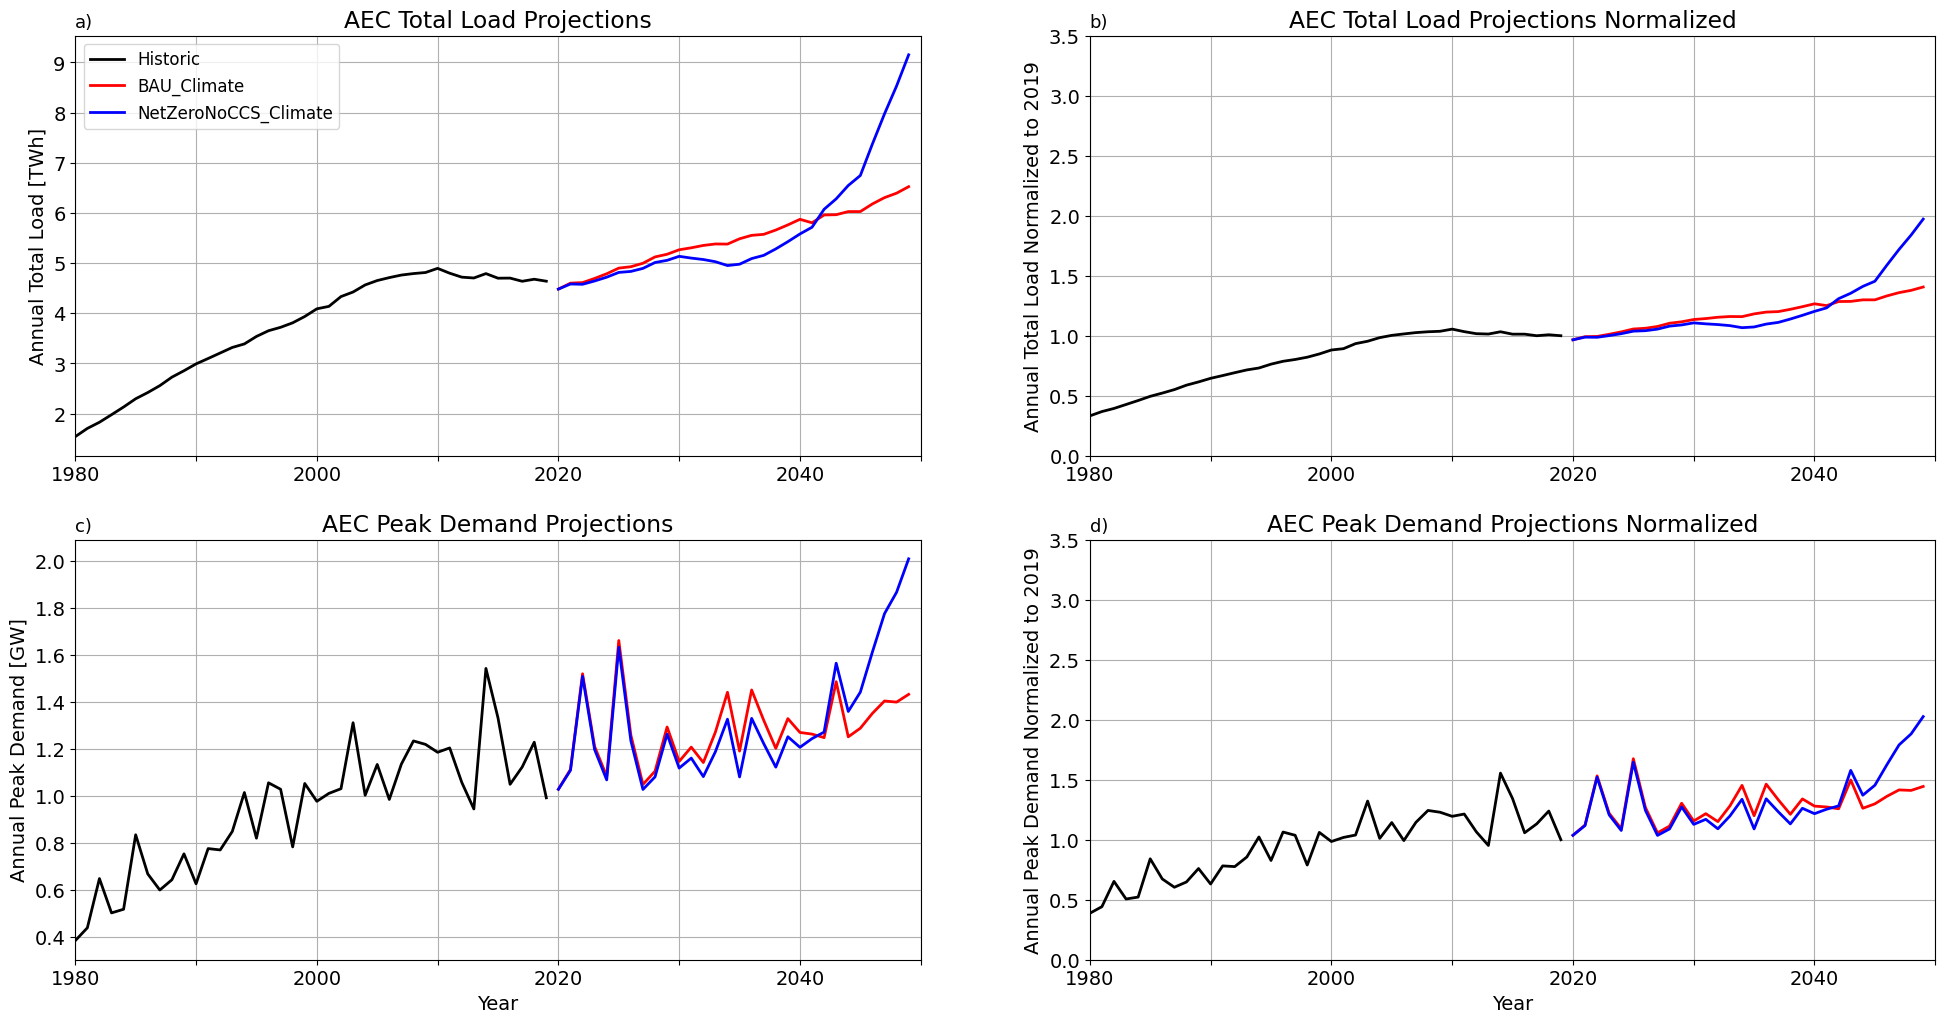

In [10]:
# Make a list of all of the states in the 'output_df' created above:
bas = output_df['BA'].unique()
         
# Loop over the states and make the plot for each state:
#for i in range(len(bas)):
for i in range(1):
    plot_ba_load_time_series(ba_to_plot = bas[i],
                             data_input_dir = data_output_dir, 
                             image_output_dir = image_output_dir, 
                             image_resolution = 50, 
                             save_images = False)
